## Car number Detection with Python
> - Python 3.7
> - Opencv 4.1.0
> - Pytesseract 0.3.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pytesseract

## 1. Image Load

In [2]:
image = cv2.imread('./images/carnumber.jpg')
orig = image.copy()

## 2. Image rescale & Edge Detection

STEP 1: Edge Detection


-1

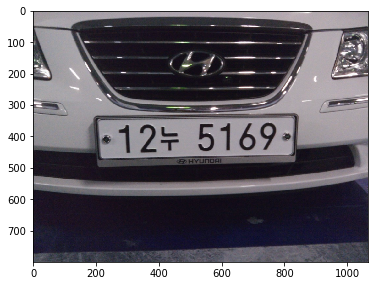

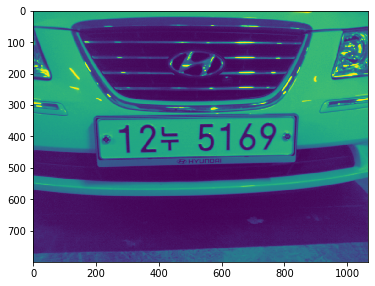

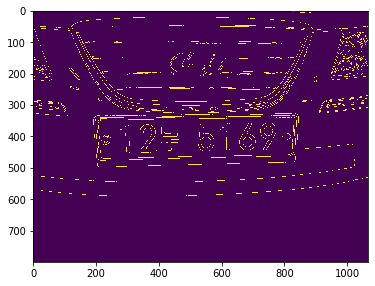

In [3]:
# img resize
r = 800.0 / image.shape[0]
dim = (int(image.shape[1] * r), 800)
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # grayscale
gray = cv2.GaussianBlur(gray, (3, 3), 0)        # blur
edged = cv2.Canny(gray, 75, 200)                # edge 검출

# show the original image and the edge detected image
print("STEP 1: Edge Detection")
for i, img in enumerate([image, gray, edged]):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

## 3. Find Car number plate

STEP 2: Find contours of paper


-1

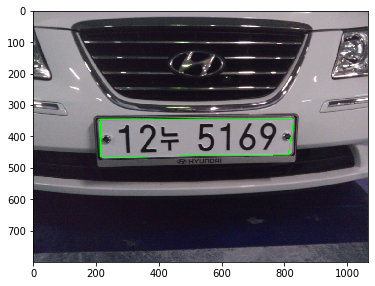

In [4]:
# 외각을 찾은 후 가장 큰 외각 순서대로 반환
(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]  # contour면적이 가장 큰 큰 순서대로 받아옴

# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True) # 0.2오차로 근사

    # 만약 추출한 외각의 꼭지점이 4개라면, 그것을 외각으로 판단
    if len(approx) == 4:
        screenCnt = approx
        break

# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
plt.figure(figsize=(6, 6))
plt.imshow(image)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

## 4. Crop number plate &  Perspective Transformation

In [5]:
def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")

	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# compute the difference between the points
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	# return the ordered coordinates
	return rect

STEP 3: Apply perspective transform


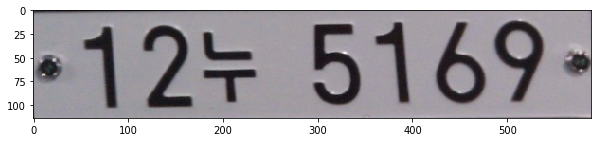

-1

In [6]:
# 4개의 꼭지점을 기준으로 투영변환
rect = order_points(screenCnt.reshape(4, 2) / r)    # 4개의 꼭지점을 정렬
(topLeft, topRight, bottomRight, bottomLeft) = rect

w1 = abs(bottomRight[0] - bottomLeft[0])
w2 = abs(topRight[0] - topLeft[0])
h1 = abs(topRight[1] - bottomRight[1])
h2 = abs(topLeft[1] - bottomLeft[1])
maxWidth = max([w1, w2])
maxHeight = max([h1, h2])

dst = np.float32([[0,0], [maxWidth-1,0], 
                  [maxWidth-1,maxHeight-1], [0,maxHeight-1]])

M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))

# show the original and scanned images
print("STEP 3: Apply perspective transform")
plt.figure(figsize=(10, 6))
plt.imshow(warped)
plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

## 5. Gray Scale & Save img

STEP 4: Apply Adaptive Threshold


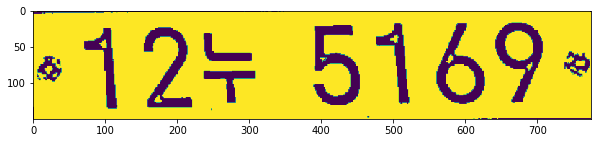

-1

In [7]:
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
warped = cv2.adaptiveThreshold(warped, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 10)

# 이미지 크기 조정
r = 150.0 / warped.shape[0]
dim = (int(warped.shape[1] * r), 150)
warped = cv2.resize(warped, dim, interpolation = cv2.INTER_AREA)

# show the original and scanned images
print("STEP 4: Apply Adaptive Threshold")
plt.figure(figsize=(10, 6))
plt.imshow(warped)
plt.show()

# save img
cv2.imwrite('scannedImage.png', warped)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

## 6. Optical character recognition by pytesseract

In [8]:
# tesseact 경로지정
tesseract_path = 'C:/Program Files/Tesseract-OCR'
pytesseract.pytesseract.tesseract_cmd = tesseract_path + '/tesseract.exe'

def ocr_tesseract():
    image_file = 'scannedImage.png'
    im = Image.open(image_file)
    text = pytesseract.image_to_string(im,lang='kor')
    print('Scanned Car number : {}'.format(text))
        
ocr_tesseract()

Scanned Car number : 12누 5169
